In [8]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터 경로 설정
data_dirs = {
    "train": {
        "images": "C:/sample_ex3000/filtered_defect/train/images/",
        "masks": "C:/sample_ex3000/filtered_defect/train/masks_binary/"
    },
    "val": {
        "images": "C:/sample_ex3000/filtered_defect/val/images/",
        "masks": "C:/sample_ex3000/filtered_defect/val/masks_binary/"
    },
    "test": {
        "images": "C:/sample_ex3000/filtered_defect/test/images/",
        "masks": "C:/sample_ex3000/filtered_defect/test/masks_binary/"
    }
}

# 데이터 불러오는 함수
def load_data(image_dir, mask_dir):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    X, Y = [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # 이미지 & 마스크 로드
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # 모델 입력 크기에 맞게 조정
        img = img / 255.0  # 정규화

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (224, 224))  # 모델 출력 크기에 맞게 조정
        mask = (mask > 127).astype(np.uint8)  # 0 또는 1로 변환

        X.append(img)
        Y.append(mask)

    # NumPy 배열로 변환
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.uint8).reshape(-1, 224, 224, 1)  # (batch, height, width, 1)

    return X, Y

# 데이터셋 로드
X_train, Y_train = load_data(data_dirs["train"]["images"], data_dirs["train"]["masks"])
X_val, Y_val = load_data(data_dirs["val"]["images"], data_dirs["val"]["masks"])
X_test, Y_test = load_data(data_dirs["test"]["images"], data_dirs["test"]["masks"])

# 데이터 크기 출력
print(f"훈련 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}, 테스트 데이터 크기: {X_test.shape}")
print(f"훈련 마스크 고유값: {np.unique(Y_train)}")  # 0과 1만 있는지 확인

훈련 데이터 크기: (1587, 224, 224, 3), 검증 데이터 크기: (225, 224, 224, 3), 테스트 데이터 크기: (188, 224, 224, 3)
훈련 마스크 고유값: [0 1]


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터 경로 설정
data_dirs = {
    "train": {
        "images": "D:/sample_ex3000/train/images/",
        "masks": "D:/sample_ex3000/train/masks_binary/"
    },
    "val": {
        "images": "D:/sample_ex3000/val/iamges",
        "masks": "C:/sample_ex3000/val/masks_binary/"
    },
    "test": {
        "images": "D:/sample_ex3000/test/images",
        "masks": "D:/sample_ex3000/test/masks_binary/"
    }
}

# 데이터 불러오는 함수
def load_data(image_dir, mask_dir):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    X, Y = [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # 이미지 & 마스크 로드
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # 모델 입력 크기에 맞게 조정
        img = img / 255.0  # 정규화

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (224, 224))  # 모델 출력 크기에 맞게 조정
        mask = (mask > 127).astype(np.float32)  # float32로 변경

        X.append(img)
        Y.append(mask)

    # NumPy 배열로 변환
    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32).reshape(-1, 224, 224, 1)  # (batch, height, width, 1)

    return X, Y

# 데이터셋 로드
X_train, Y_train = load_data(data_dirs["train"]["images"], data_dirs["train"]["masks"])
X_val, Y_val = load_data(data_dirs["val"]["images"], data_dirs["val"]["masks"])
X_test, Y_test = load_data(data_dirs["test"]["images"], data_dirs["test"]["masks"])

# 데이터 크기 출력
print(f"훈련 데이터 크기: {X_train.shape}, 검증 데이터 크기: {X_val.shape}, 테스트 데이터 크기: {X_test.shape}")
print(f"훈련 마스크 고유값: {np.unique(Y_train)}")  # 0과 1만 있는지 확인

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 개선된 Focal Loss (α=0.9로 조정)
def focal_loss(alpha=0.9, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)  # log(0) 방지
        loss = -alpha * y_true * tf.keras.backend.pow(1 - y_pred, gamma) * tf.keras.backend.log(y_pred) \
               - (1 - alpha) * (1 - y_true) * tf.keras.backend.pow(y_pred, gamma) * tf.keras.backend.log(1 - y_pred)
        return tf.keras.backend.mean(loss)
    return loss

# 개선된 U-Net + MobileNetV2 모델 정의
def build_unet_mobilenet(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")

    # Encoder에서 Skip Connection 가져오기
    skips = [
        base_model.get_layer("block_1_expand_relu").output,  # (112, 112, 96)
        base_model.get_layer("block_3_expand_relu").output,  # (56, 56, 144)
        base_model.get_layer("block_6_expand_relu").output,  # (28, 28, 192)
        base_model.get_layer("block_13_expand_relu").output,  # (14, 14, 576)
    ]
    encoder_output = base_model.get_layer("block_16_project").output  # (7, 7, 320)

    # Decoder (업샘플링)
    up_stack = [
        (256, (3, 3)),  # (14, 14, 256)
        (128, (3, 3)),  # (28, 28, 128)
        (64, (3, 3)),   # (56, 56, 64)
        (32, (3, 3)),   # (112, 112, 32)
    ]

    x = encoder_output
    for (filters, kernel_size), skip in zip(up_stack, reversed(skips)):
        x = layers.Conv2DTranspose(filters, kernel_size, strides=2, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)  # Batch Normalization 추가
        x = layers.Dropout(0.2)(x)  # Dropout 추가
        x = layers.concatenate([x, skip])
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)

    # 최종 업샘플링
    x = layers.Conv2DTranspose(16, (3, 3), strides=2, padding="same", activation="relu")(x)
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)  # 1채널 마스크 (Sigmoid 활성화)

    return Model(inputs=base_model.input, outputs=outputs)

# 모델 생성
model = build_unet_mobilenet()
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # 최적 Learning Rate 설정
    loss=focal_loss(alpha=0.9, gamma=2.0),
    metrics=["accuracy"]  # Dice Score는 별도 계산 가능
)

# EarlyStopping 수정: mode="max" 추가
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True)  # ✅ 성능 최적화
]

# 학습 실행
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=8,  # 기존과 동일
    callbacks=callbacks
)

# 최종 모델 하나만 저장
model.save("fine_tuned_unet_mobilenet_alpha09.h5")
print("학습 완료: fine_tuned_unet_mobilenet_alpha09.h5 저장 완료")

In [20]:
thresholds = np.arange(0.4, 0.6, 0.05)
best_threshold = 0
best_dice_score = 0

for t in thresholds:
    predictions_binary = (predictions > t).astype(np.uint8)
    dices = [compute_dice(Y_test[i].squeeze(), predictions_binary[i].squeeze()) for i in range(len(Y_test))]
    mean_dice = np.mean(dices)

    if mean_dice > best_dice_score:
        best_dice_score = mean_dice
        best_threshold = t

print(f"최적 Threshold: {best_threshold:.3f}, 최고 Dice Score: {best_dice_score:.4f}")

최적 Threshold: 0.400, 최고 Dice Score: 0.5363


6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 890ms/step
평균 IoU Score: 0.3992
평균 Dice Score: 0.5363


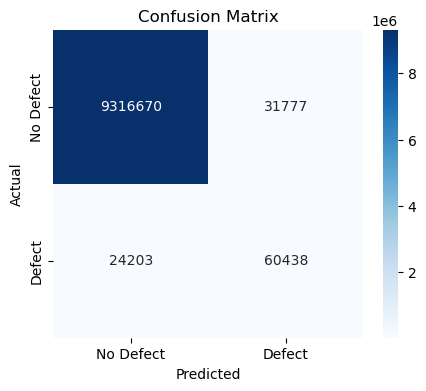


 Classification Report
              precision    recall  f1-score   support

   No Defect       1.00      1.00      1.00   9348447
      Defect       0.66      0.71      0.68     84641

    accuracy                           0.99   9433088
   macro avg       0.83      0.86      0.84   9433088
weighted avg       0.99      0.99      0.99   9433088



In [27]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 모델 불러오기
model = tf.keras.models.load_model("final_unet_mobilenet_224.h5", compile=False)

# IoU (Intersection over Union) 계산 함수
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 0

# Dice Score 계산 함수
def compute_dice(y_true, y_pred, smooth=1e-6):
    intersection = np.logical_and(y_true, y_pred).sum()
    return (2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

# 예측 수행 (X_test 데이터 사용)
predictions = model.predict(X_test)

#  최적 Threshold 적용
threshold = 0.4
predictions_binary = (predictions > threshold).astype(np.uint8)

# 전체 테스트셋에 대한 성능 평가
ious, dices = [], []
for i in range(len(Y_test)):
    iou_score = compute_iou(Y_test[i].squeeze(), predictions_binary[i].squeeze())
    dice_score = compute_dice(Y_test[i].squeeze(), predictions_binary[i].squeeze())
    ious.append(iou_score)
    dices.append(dice_score)

# 평균 IoU & Dice Score 출력
print(f"평균 IoU Score: {np.mean(ious):.4f}")
print(f"평균 Dice Score: {np.mean(dices):.4f}")

# Confusion Matrix 생성
y_true_flat = Y_test.flatten()
y_pred_flat = predictions_binary.flatten()
cm = confusion_matrix(y_true_flat, y_pred_flat)

# 혼동 행렬 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Defect", "Defect"], yticklabels=["No Defect", "Defect"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 상세 성능 출력
print("\n Classification Report")
print(classification_report(y_true_flat, y_pred_flat, target_names=["No Defect", "Defect"]))

In [28]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 기존 학습된 모델 불러오기
model = load_model("final_unet_mobilenet_224.h5", compile=False)

# 기존과 동일한 학습 설정 유지
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 기존보다 낮은 학습률 (fine-tuning에 적합)
    loss="binary_crossentropy",  # 기존과 동일한 손실 함수 사용
    metrics=["accuracy"]  # Dice Score는 평가 코드에서 별도 계산
)

# EarlyStopping 설정 (mode="max" 추가)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True)

# 추가 학습 실행
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=10,  # 추가 학습 10 에포크 진행
    batch_size=8,  # 기존과 동일
    callbacks=[early_stopping]
)

# 추가 학습된 모델 저장 (새로운 이름으로 저장)
model.save("fine_tuned_unet_mobilenet_224.h5")
print("Fine-Tuning 완료: fine_tuned_unet_mobilenet_224.h5")

Epoch 1/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 216s 985ms/step - accuracy: 0.9966 - loss: 0.0135 - val_accuracy: 0.9933 - val_loss: 0.0202
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 189s 950ms/step - accuracy: 0.9970 - loss: 0.0082 - val_accuracy: 0.9934 - val_loss: 0.0207
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 189s 950ms/step - accuracy: 0.9970 - loss: 0.0076 - val_accuracy: 0.9934 - val_loss: 0.0209
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 189s 949ms/step - accuracy: 0.9971 - loss: 0.0073 - val_accuracy: 0.9934 - val_loss: 0.0212
Epoch 5/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 191s 959ms/step - accuracy: 0.9971 - loss: 0.0071 - val_accuracy: 0.9934 - val_loss: 0.0216
Epoch 6/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 187s 941ms/step - accuracy: 0.9971 - loss: 0.0072 - val_accuracy: 0.9934 - val_loss: 0.0218
Epoch 7/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 189s 948ms/step - accuracy: 0.9971 - loss: 0.0071 - val_accuracy: 0.9934 - val_loss: 0.0214
Epoch 8/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 188s 946ms/step - accuracy: 0.9972 -

Fine-Tuning 완료: fine_tuned_unet_mobilenet_224.h5


In [32]:
#최적의 임계값 찾기
import numpy as np

# 여러 Threshold 값에서 Dice Score 계산
thresholds = np.arange(0.01, 0.6, 0.01)  # 0.01 ~ 0.50까지 0.01 간격으로 설정
dice_scores = []

# Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, threshold, smooth=1e-6):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# 여러 Threshold에 대한 Dice Score 측정
for threshold in thresholds:
    scores = [dice_coefficient(Y_test[i], predictions[i], threshold) for i in range(len(Y_test))]
    mean_dice = np.mean(scores)
    dice_scores.append((threshold, mean_dice))
    print(f"Threshold={threshold:.3f} → 평균 Dice Score: {mean_dice:.4f}")

# 최적 Threshold 찾기
best_threshold, best_dice = max(dice_scores, key=lambda x: x[1])
print(f"\n최적 Threshold: {best_threshold:.3f}, 최고 Dice Score: {best_dice:.4f}")

Threshold=0.010 → 평균 Dice Score: 0.4089
Threshold=0.020 → 평균 Dice Score: 0.4471
Threshold=0.030 → 평균 Dice Score: 0.4682
Threshold=0.040 → 평균 Dice Score: 0.4814
Threshold=0.050 → 평균 Dice Score: 0.4914
Threshold=0.060 → 평균 Dice Score: 0.4994
Threshold=0.070 → 평균 Dice Score: 0.5057
Threshold=0.080 → 평균 Dice Score: 0.5108
Threshold=0.090 → 평균 Dice Score: 0.5155
Threshold=0.100 → 평균 Dice Score: 0.5194
Threshold=0.110 → 평균 Dice Score: 0.5224
Threshold=0.120 → 평균 Dice Score: 0.5250
Threshold=0.130 → 평균 Dice Score: 0.5279
Threshold=0.140 → 평균 Dice Score: 0.5298
Threshold=0.150 → 평균 Dice Score: 0.5315
Threshold=0.160 → 평균 Dice Score: 0.5330
Threshold=0.170 → 평균 Dice Score: 0.5343
Threshold=0.180 → 평균 Dice Score: 0.5351
Threshold=0.190 → 평균 Dice Score: 0.5363
Threshold=0.200 → 평균 Dice Score: 0.5372
Threshold=0.210 → 평균 Dice Score: 0.5380
Threshold=0.220 → 평균 Dice Score: 0.5380
Threshold=0.230 → 평균 Dice Score: 0.5386
Threshold=0.240 → 평균 Dice Score: 0.5389
Threshold=0.250 → 평균 Dice Score: 0.5388


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# 모델 불러오기
model = load_model("fine_tuned_unet_mobilenet_224.h5", compile=False)

# 테스트 데이터 예측
predictions = model.predict(X_test)

# Threshold 적용 (최적값 0.4 기준)
threshold = 0.27
predictions_binary = (predictions > threshold).astype(np.uint8)

# Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# IoU 계산 함수
def iou_score(y_true, y_pred, smooth=1e-6):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# 전체 테스트셋 성능 평가
dice_scores = [dice_coefficient(Y_test[i], predictions_binary[i]) for i in range(len(Y_test))]
iou_scores = [iou_score(Y_test[i], predictions_binary[i]) for i in range(len(Y_test))]

print(f"평균 Dice Score: {np.mean(dice_scores):.4f}")
print(f"평균 IoU Score: {np.mean(iou_scores):.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 890ms/step
평균 Dice Score: 0.5398
평균 IoU Score: 0.4028


In [58]:
#검증 데이터 최적 threshold찾기
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# 최적 Threshold 찾는 함수
def find_best_threshold(model, X_val, Y_val, thresholds=np.arange(0.2, 0.35, 0.01)):
    best_threshold = 0
    best_dice = 0

    for threshold in thresholds:
        preds = model.predict(X_val)
        preds_binary = (preds > threshold).astype(np.uint8)

        dice_scores = [dice_coefficient(Y_val[i], preds_binary[i]) for i in range(len(Y_val))]
        mean_dice = np.mean(dice_scores)

        print(f"Threshold={threshold:.3f} → 평균 Dice Score: {mean_dice:.4f}")

        if mean_dice > best_dice:
            best_dice = mean_dice
            best_threshold = threshold

    return best_threshold, best_dice

# 모델 불러오기
model = load_model("fine_tuned_unet_mobilenet_224.h5", compile=False)

# 최적 Threshold 찾기
best_threshold, best_dice = find_best_threshold(model, X_val, Y_val)
print(f"최적 Threshold: {best_threshold:.3f}, 최고 Dice Score: {best_dice:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 761ms/step
Threshold=0.200 → 평균 Dice Score: 0.5504
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 654ms/step
Threshold=0.210 → 평균 Dice Score: 0.5507
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step
Threshold=0.220 → 평균 Dice Score: 0.5509
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 618ms/step
Threshold=0.230 → 평균 Dice Score: 0.5512
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step
Threshold=0.240 → 평균 Dice Score: 0.5511
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 622ms/step
Threshold=0.250 → 평균 Dice Score: 0.5508
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 647ms/step
Threshold=0.260 → 평균 Dice Score: 0.5505
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step
Threshold=0.270 → 평균 Dice Score: 0.5495
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 638ms/step
Threshold=0.280 → 평균 Dice Score: 0.5493
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step
Threshold=0.290 → 평균 Dice Score: 0.5477
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 632ms/step
Threshold=0.300 → 평균 Dice Score: 0.5474
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 629ms/step
Threshold=0.310 → 평균 Dice Score: 0.5468
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 621ms/step
Threshold=0.3

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 745ms/step
성능 평가 (Threshold=0.23)
평균 Dice Score: 0.5512
평균 IoU Score: 0.4159


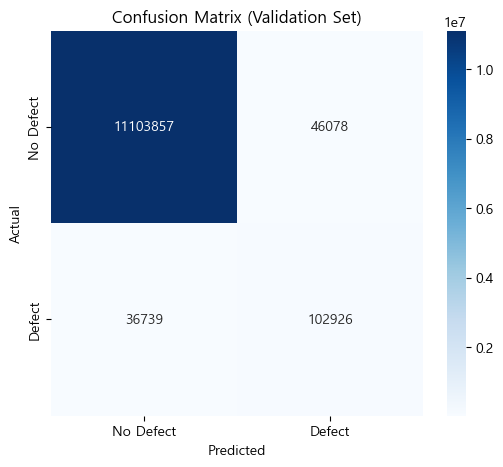


Classification Report (Validation Set):

              precision    recall  f1-score   support

   No Defect       1.00      1.00      1.00  11149935
      Defect       0.69      0.74      0.71    139665

    accuracy                           0.99  11289600
   macro avg       0.84      0.87      0.85  11289600
weighted avg       0.99      0.99      0.99  11289600



In [59]:
#검증 데이터 성능 평가
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 불러오기 (현재 사용 중인 모델)
model = load_model("fine_tuned_unet_mobilenet_224.h5", compile=False)

# 검증 데이터 예측
predictions = model.predict(X_val)

# 최적 Threshold 적용 
threshold = 0.23
predictions_binary = (predictions > threshold).astype(np.uint8)

# Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# IoU Score 계산 함수
def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# 전체 검증셋 성능 평가
dice_scores = [dice_coefficient(Y_val[i], predictions_binary[i]) for i in range(len(Y_val))]
iou_scores = [iou_score(Y_val[i], predictions_binary[i]) for i in range(len(Y_val))]

# 평균 성능 출력
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)
print(f"성능 평가 (Threshold={threshold:.2f})")
print(f"평균 Dice Score: {mean_dice:.4f}")
print(f"평균 IoU Score: {mean_iou:.4f}")

# 혼동 행렬 계산
y_true_flat = Y_val.flatten()
y_pred_flat = predictions_binary.flatten()
cm = confusion_matrix(y_true_flat, y_pred_flat)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Defect", "Defect"], yticklabels=["No Defect", "Defect"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

#  Classification Report 출력
print("\nClassification Report (Validation Set):\n")
print(classification_report(y_true_flat, y_pred_flat, target_names=["No Defect", "Defect"]))

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 904ms/step


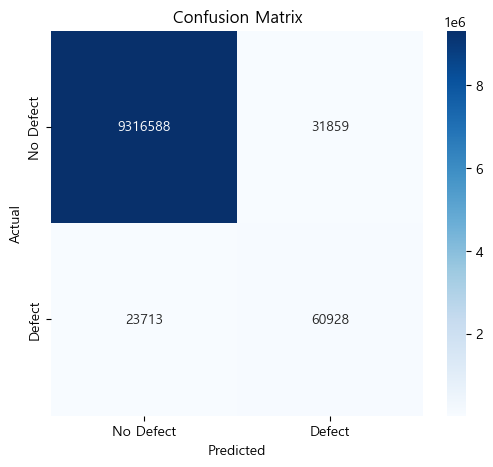


 Classification Report:
              precision    recall  f1-score   support

   No Defect       1.00      1.00      1.00   9348447
      Defect       0.66      0.72      0.69     84641

    accuracy                           0.99   9433088
   macro avg       0.83      0.86      0.84   9433088
weighted avg       0.99      0.99      0.99   9433088



In [47]:
#테스트 데이터 성능평가
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# 모델 불러오기
model = load_model("fine_tuned_unet_mobilenet_224.h5", compile=False)

# 테스트 데이터 예측
predictions = model.predict(X_test)

# Threshold 적용 (최적값 0.27 기준)
threshold = 0.27
predictions_binary = (predictions > threshold).astype(np.uint8)

# Confusion Matrix 계산
y_true_flat = Y_test.flatten()
y_pred_flat = predictions_binary.flatten()
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Defect", "Defect"], yticklabels=["No Defect", "Defect"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report 출력
print("\n Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=["No Defect", "Defect"]))

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# 모델 불러오기
model = load_model("fine_tuned_unet_mobilenet_224.h5", compile=False)

# 테스트 데이터 예측
predictions = model.predict(X_test)

# Threshold 적용 (최적값 0.4 기준)
threshold = 0.27
predictions_binary = (predictions > threshold).astype(np.uint8)

# Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# IoU 계산 함수
def iou_score(y_true, y_pred, smooth=1e-6):
    y_pred = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# 전체 테스트셋 성능 평가
dice_scores = [dice_coefficient(Y_test[i], predictions_binary[i]) for i in range(len(Y_test))]
iou_scores = [iou_score(Y_test[i], predictions_binary[i]) for i in range(len(Y_test))]

print(f"평균 Dice Score: {np.mean(dice_scores):.4f}")
print(f"평균 IoU Score: {np.mean(iou_scores):.4f}")

# 혼동 행렬 및 Precision-Recall-F1 Score
y_true_flat = Y_test.flatten()
y_pred_flat = predictions_binary.flatten()

cm = confusion_matrix(y_true_flat, y_pred_flat)
print("Confusion Matrix:\n", cm)

report = classification_report(y_true_flat, y_pred_flat, target_names=["No Defect", "Defect"])
print("Classification Report:\n", report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 896ms/step
평균 Dice Score: 0.5398
평균 IoU Score: 0.4028
Confusion Matrix:
 [[9316588   31859]
 [  23713   60928]]
Classification Report:
               precision    recall  f1-score   support

   No Defect       1.00      1.00      1.00   9348447
      Defect       0.66      0.72      0.69     84641

    accuracy                           0.99   9433088
   macro avg       0.83      0.86      0.84   9433088
weighted avg       0.99      0.99      0.99   9433088



In [38]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc("font", family="Malgun Gothic")  # Windows의 경우
# plt.rc("font", family="AppleGothic")  # Mac의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


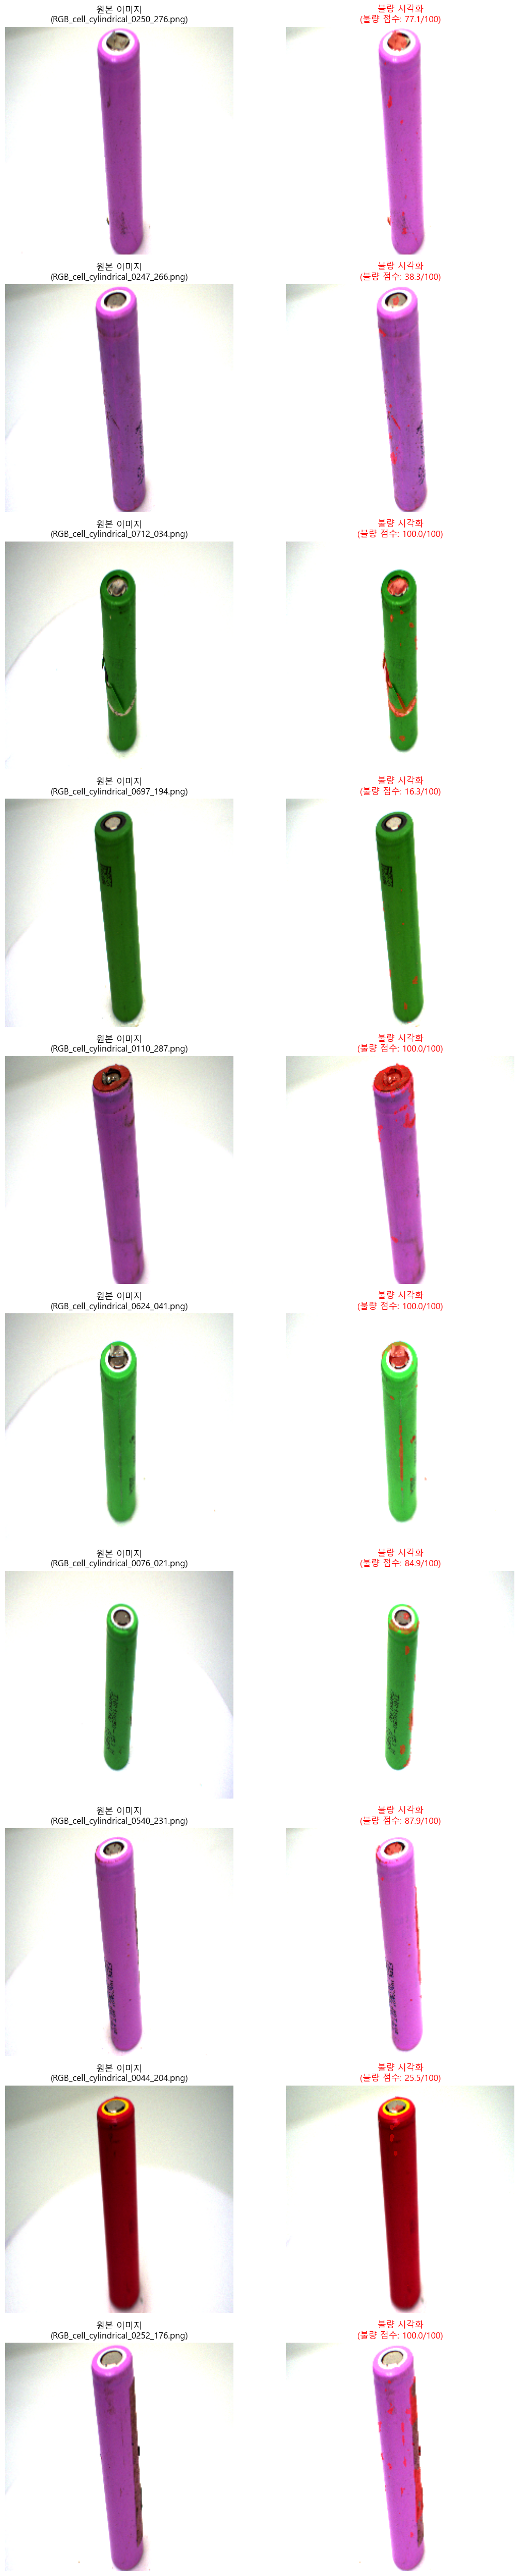

In [48]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 경로 설정
image_dir = r"C:\sample_ex3000\filtered_defect\test\images"
model_path = "final_unet_mobilenet_224.h5" 

# 모델 불러오기
model = load_model(model_path, compile=False)

# 랜덤 10개 이미지 선택
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(image_files, 10)

# 이미지 예측 및 시각화
fig, axes = plt.subplots(10, 2, figsize=(12, 50))

for i, img_name in enumerate(selected_images):
    # 이미지 로드 및 전처리
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0  # 정규화

    # 모델 예측
    pred_mask = model.predict(np.expand_dims(img_resized, axis=0))[0]
    pred_mask = (pred_mask > 0.27).astype(np.uint8)  # 최적 Threshold 적용 (0.27)

    # 불량 픽셀 비율 계산 (100점 만점 변환)
    defect_ratio = np.sum(pred_mask) / (224 * 224)  # 전체 픽셀 대비 불량 픽셀 비율
    defect_score = min(defect_ratio * 10000, 100)  # **불량 픽셀 비율을 100점 기준으로 변환**

    # 배경 유지 + 불량 부분만 빨간색으로 덧씌우기
    mask_colored = img_resized.copy() * 255  # 원본 유지
    mask_colored[:, :, 0] = np.where(pred_mask[:, :, 0] == 1, 255, mask_colored[:, :, 0])  # 빨간색 채널
    mask_colored[:, :, 1] = np.where(pred_mask[:, :, 0] == 1, 0, mask_colored[:, :, 1])  # 초록색 제거
    mask_colored[:, :, 2] = np.where(pred_mask[:, :, 0] == 1, 0, mask_colored[:, :, 2])  # 파란색 제거

    overlay = cv2.addWeighted((img_resized * 255).astype(np.uint8), 0.8, mask_colored.astype(np.uint8), 0.5, 0)

    # 원본 & 마스크 시각화
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"원본 이미지\n({img_name})", fontsize=12)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title(f"불량 시각화\n(불량 점수: {defect_score:.1f}/100)", fontsize=12, color="red")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

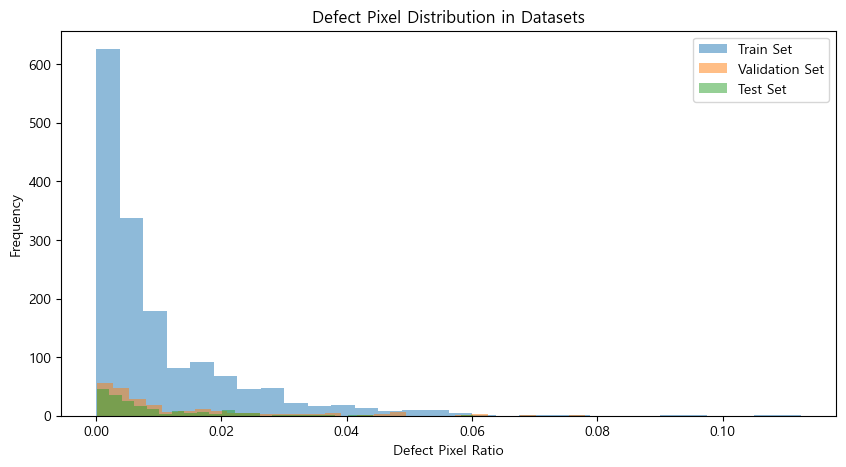

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# 불량 마스크 픽셀 비율 확인
def analyze_mask_distribution(Y_train, Y_val, Y_test):
    datasets = {'Train': Y_train, 'Validation': Y_val, 'Test': Y_test}
    
    plt.figure(figsize=(10, 5))
    
    for i, (name, dataset) in enumerate(datasets.items(), 1):
        defect_ratios = [np.sum(mask) / (mask.shape[0] * mask.shape[1]) for mask in dataset]
        plt.hist(defect_ratios, bins=30, alpha=0.5, label=f"{name} Set")
    
    plt.xlabel("Defect Pixel Ratio")
    plt.ylabel("Frequency")
    plt.title("Defect Pixel Distribution in Datasets")
    plt.legend()
    plt.show()

# 실행 (Y_train, Y_val, Y_test는 불량 마스크 데이터)
analyze_mask_distribution(Y_train, Y_val, Y_test)

C:\Users\enjoy\AppData\Local\Temp\ipykernel_22964\2282682143.py:17: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=0),  # 회전 (불량 영역 유지)
C:\Users\enjoy\AppData\Local\Temp\ipykernel_22964\2282682143.py:18: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.03, rotate_limit=5, border_mode=cv2.BORDER_CONSTANT, value=0),  # 이동 & 확대 최소화


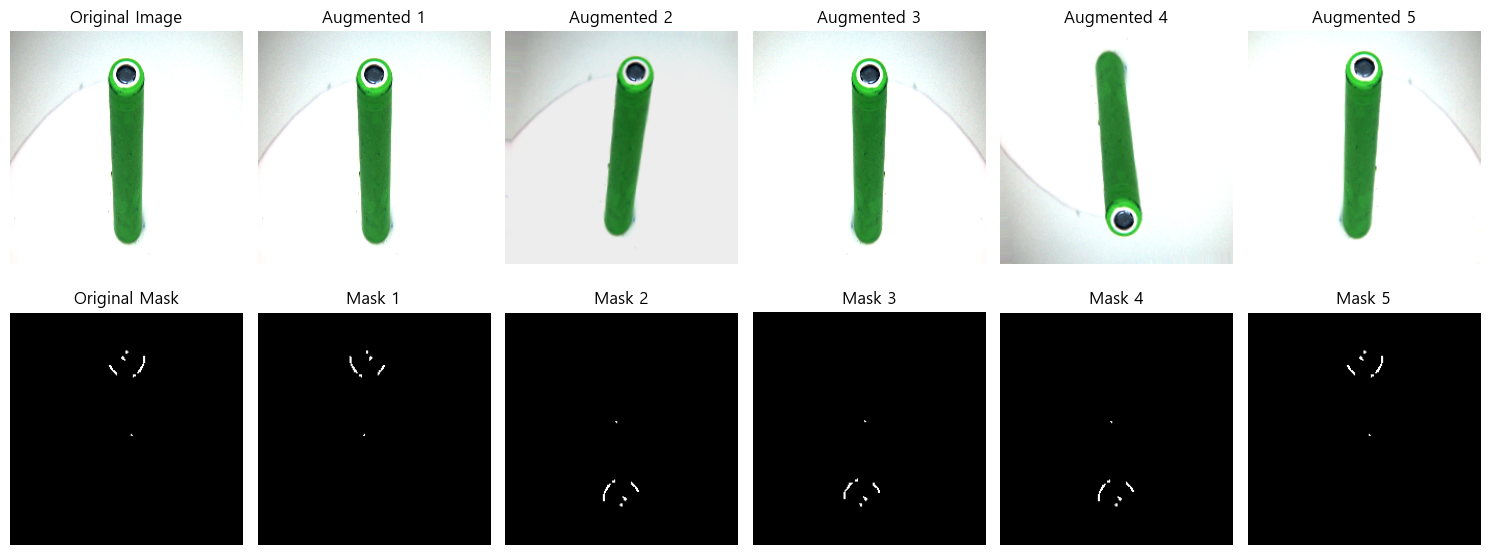

In [68]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A

# 증강기 (배경 및 색 유지)
image_transform = A.Compose([
    A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE),  # 회전 (배경 유지)
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.03, rotate_limit=5, border_mode=cv2.BORDER_REPLICATE),  # 이동 & 확대 최소화
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05),  # 밝기 & 대비 최소 조정
    A.HorizontalFlip(p=0.5),  # 좌우 반전
    A.VerticalFlip(p=0.5),  # 상하 반전
])

# 마스크 변환 (불량 영역 유지)
mask_transform = A.Compose([
    A.Rotate(limit=10, border_mode=cv2.BORDER_CONSTANT, value=0),  # 회전 (불량 영역 유지)
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.03, rotate_limit=5, border_mode=cv2.BORDER_CONSTANT, value=0),  # 이동 & 확대 최소화
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

# 샘플 데이터 선택
sample_idx = np.random.randint(len(X_train))
sample_image = (X_train[sample_idx] * 255).astype(np.uint8)  # 0~255 범위 변환
sample_mask = (Y_train[sample_idx] * 255).astype(np.uint8)  # 0~255 범위 변환

# 증강된 이미지 & 마스크 생성
augmented_images, augmented_masks = [], []

for _ in range(5):
    augmented_img = image_transform(image=sample_image)["image"]
    augmented_mask = mask_transform(image=sample_mask)["image"]

    # 마스크 보정 (0과 255만 유지)
    augmented_mask = np.where(augmented_mask > 127, 255, 0).astype(np.uint8)

    augmented_images.append(augmented_img)
    augmented_masks.append(augmented_mask)

# 시각화
fig, axes = plt.subplots(2, 6, figsize=(15, 6))

# 원본 이미지 & 마스크
axes[0, 0].imshow(sample_image)
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(sample_mask, cmap="gray")
axes[1, 0].set_title("Original Mask")

# 증강된 이미지 & 마스크
for i in range(5):
    axes[0, i+1].imshow(augmented_images[i])
    axes[0, i+1].set_title(f"Augmented {i+1}")
    
    axes[1, i+1].imshow(augmented_masks[i], cmap="gray")
    axes[1, i+1].set_title(f"Mask {i+1}")

# 시각화 설정
for ax in axes.flat:
    ax.axis("off")
plt.tight_layout()
plt.show()  #이미지 증강과정
#위 방식대로 이미지 증강 진행했지만, 성능이 나아지지 않아 이미지 증강은 하지 않음

In [81]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Focal Loss (α=0.8 적용)
def focal_loss(alpha=0.8, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)  # log(0) 방지
        loss = -alpha * y_true * tf.keras.backend.pow(1 - y_pred, gamma) * tf.keras.backend.log(y_pred) \
               - (1 - alpha) * (1 - y_true) * tf.keras.backend.pow(y_pred, gamma) * tf.keras.backend.log(1 - y_pred)
        return tf.keras.backend.mean(loss)
    return loss

#  기존 모델 불러오기 (α=0.6로 학습된 모델)
model = load_model("fine_tuned_unet_mobilenet_224.h5", compile=False)

#  α=0.8 적용 후 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(alpha=0.8, gamma=2.0),
    metrics=["accuracy"]
)

# 콜백 설정 (EarlyStopping)
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, mode="max", restore_best_weights=True)
]

# 추가 학습 진행 (15 에포크)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=15,
    batch_size=8,
    callbacks=callbacks
)

# 새로운 모델 저장 (α=0.8 적용 버전)
model.save("fine_tuned_unet_mobilenet_alpha08.h5")
print("학습 완료: fine_tuned_unet_mobilenet_alpha08.h5 저장 완료")

Epoch 1/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.9959 - loss: 9.4153e-04 - val_accuracy: 0.9924 - val_loss: 0.0037
Epoch 2/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 197s 988ms/step - accuracy: 0.9961 - loss: 7.8285e-04 - val_accuracy: 0.9924 - val_loss: 0.0037
Epoch 3/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 196s 985ms/step - accuracy: 0.9959 - loss: 7.9751e-04 - val_accuracy: 0.9923 - val_loss: 0.0034
Epoch 4/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 195s 980ms/step - accuracy: 0.9961 - loss: 7.7218e-04 - val_accuracy: 0.9920 - val_loss: 0.0036
Epoch 5/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 196s 983ms/step - accuracy: 0.9961 - loss: 7.5000e-04 - val_accuracy: 0.9924 - val_loss: 0.0041
Epoch 6/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 196s 985ms/step - accuracy: 0.9961 - loss: 7.4724e-04 - val_accuracy: 0.9913 - val_loss: 0.0032
Epoch 7/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 197s 988ms/step - accuracy: 0.9961 - loss: 7.4239e-04 - val_accuracy: 0.9924 - val_loss: 0.0039
Epoch 8/15
199/199 ━━━━━━━━━━━━━━━━━━━━ 197s 991ms/

학습 완료: fine_tuned_unet_mobilenet_alpha08.h5 저장 완료


In [82]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# 새로운 모델 불러오기 (Focal Loss α=0.8 적용 모델)
model = load_model("fine_tuned_unet_mobilenet_alpha08.h5", compile=False)

# Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# 최적 Threshold 찾는 함수
def find_best_threshold(model, X_val, Y_val, thresholds=np.arange(0.20, 0.51, 0.01)):
    best_threshold = 0
    best_dice = 0

    for threshold in thresholds:
        preds = model.predict(X_val)
        preds_binary = (preds > threshold).astype(np.uint8)

        dice_scores = [dice_coefficient(Y_val[i], preds_binary[i]) for i in range(len(Y_val))]
        mean_dice = np.mean(dice_scores)

        print(f"Threshold={threshold:.3f} → 평균 Dice Score: {mean_dice:.4f}")

        if mean_dice > best_dice:
            best_dice = mean_dice
            best_threshold = threshold

    return best_threshold, best_dice

# 검증 데이터에서 최적 Threshold 찾기
best_threshold, best_dice = find_best_threshold(model, X_val, Y_val)
print(f"최적 Threshold: {best_threshold:.3f}, 최고 Dice Score: {best_dice:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 805ms/step
Threshold=0.200 → 평균 Dice Score: 0.4617
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 656ms/step
Threshold=0.210 → 평균 Dice Score: 0.4673
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 641ms/step
Threshold=0.220 → 평균 Dice Score: 0.4725
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 652ms/step
Threshold=0.230 → 평균 Dice Score: 0.4777
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 641ms/step
Threshold=0.240 → 평균 Dice Score: 0.4822
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 649ms/step
Threshold=0.250 → 평균 Dice Score: 0.4871
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 632ms/step
Threshold=0.260 → 평균 Dice Score: 0.4919
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step
Threshold=0.270 → 평균 Dice Score: 0.4967
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 678ms/step
Threshold=0.280 → 평균 Dice Score: 0.5008
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 646ms/step
Threshold=0.290 → 평균 Dice Score: 0.5050
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 643ms/step
Threshold=0.300 → 평균 Dice Score: 0.5088
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step
Threshold=0.310 → 평균 Dice Score: 0.5131
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 665ms/step
Threshold=0.3

In [83]:
#검증데이터
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# 새로운 모델 불러오기 (Focal Loss α=0.8 적용 모델)
model = load_model("fine_tuned_unet_mobilenet_alpha08.h5", compile=False)

# Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# 최적 Threshold 찾는 함수
def find_best_threshold(model, X_val, Y_val, thresholds=np.arange(0.5, 0.7, 0.01)):
    best_threshold = 0
    best_dice = 0

    for threshold in thresholds:
        preds = model.predict(X_val)
        preds_binary = (preds > threshold).astype(np.uint8)

        dice_scores = [dice_coefficient(Y_val[i], preds_binary[i]) for i in range(len(Y_val))]
        mean_dice = np.mean(dice_scores)

        print(f"Threshold={threshold:.3f} → 평균 Dice Score: {mean_dice:.4f}")

        if mean_dice > best_dice:
            best_dice = mean_dice
            best_threshold = threshold

    return best_threshold, best_dice

# 검증 데이터에서 최적 Threshold 찾기
best_threshold, best_dice = find_best_threshold(model, X_val, Y_val)
print(f"최적 Threshold: {best_threshold:.3f}, 최고 Dice Score: {best_dice:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 826ms/step
Threshold=0.500 → 평균 Dice Score: 0.5573
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step
Threshold=0.510 → 평균 Dice Score: 0.5576
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 645ms/step
Threshold=0.520 → 평균 Dice Score: 0.5569
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 662ms/step
Threshold=0.530 → 평균 Dice Score: 0.5562
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step
Threshold=0.540 → 평균 Dice Score: 0.5549
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 707ms/step
Threshold=0.550 → 평균 Dice Score: 0.5532
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 699ms/step
Threshold=0.560 → 평균 Dice Score: 0.5514
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 658ms/step
Threshold=0.570 → 평균 Dice Score: 0.5494
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 722ms/step
Threshold=0.580 → 평균 Dice Score: 0.5472
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 708ms/step
Threshold=0.590 → 평균 Dice Score: 0.5444
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 676ms/step
Threshold=0.600 → 평균 Dice Score: 0.5405
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 683ms/step
Threshold=0.610 → 평균 Dice Score: 0.5373
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 699ms/step
Threshold=0.6

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 795ms/step
최적 Threshold=0.51 적용 결과
평균 Dice Score: 0.5576
평균 IoU Score: 0.4214


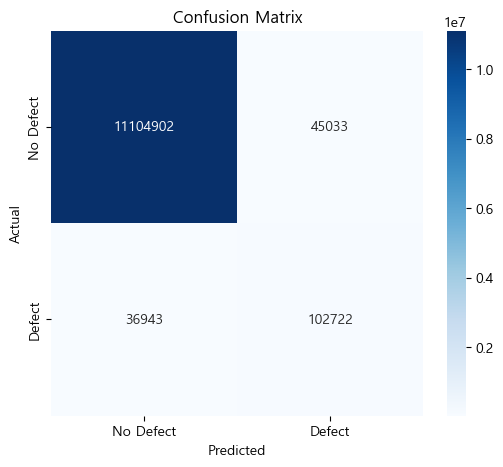


Classification Report:**

              precision    recall  f1-score   support

   No Defect       1.00      1.00      1.00  11149935
      Defect       0.70      0.74      0.71    139665

    accuracy                           0.99  11289600
   macro avg       0.85      0.87      0.86  11289600
weighted avg       0.99      0.99      0.99  11289600



In [84]:
#검증데이터 성능평가
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# 새로운 모델 불러오기 (Focal Loss α=0.8 적용 모델)
model = load_model("fine_tuned_unet_mobilenet_alpha08.h5", compile=False)

# 최적 Threshold 적용 (0.51)
threshold = 0.51

# 테스트 데이터 예측
predictions = model.predict(X_val)  
predictions_binary = (predictions > threshold).astype(np.uint8)

# Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# IoU Score 계산 함수
def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# 전체 검증 데이터 성능 평가
dice_scores = [dice_coefficient(Y_val[i], predictions_binary[i]) for i in range(len(Y_val))]
iou_scores = [iou_score(Y_val[i], predictions_binary[i]) for i in range(len(Y_val))]

# 평균 성능 출력
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)
print(f"최적 Threshold={threshold:.2f} 적용 결과")
print(f"평균 Dice Score: {mean_dice:.4f}")
print(f"평균 IoU Score: {mean_iou:.4f}")

# 혼동 행렬 계산
y_true_flat = Y_val.flatten()
y_pred_flat = predictions_binary.flatten()
cm = confusion_matrix(y_true_flat, y_pred_flat)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Defect", "Defect"], yticklabels=["No Defect", "Defect"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report 출력
print("\nClassification Report:**\n")
print(classification_report(y_true_flat, y_pred_flat, target_names=["No Defect", "Defect"]))

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 788ms/step
최적 Threshold=0.51 적용 결과
 평균 Dice Score: 0.5576
 최고 Dice Score: 0.9579
 평균 IoU Score: 0.4214
 최고 IoU Score: 0.9193


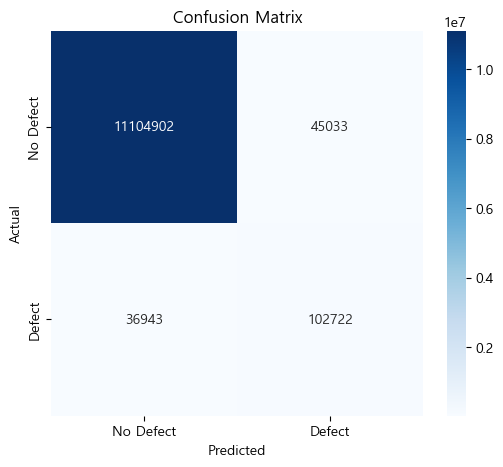


 Classification Report:**

              precision    recall  f1-score   support

   No Defect       1.00      1.00      1.00  11149935
      Defect       0.70      0.74      0.71    139665

    accuracy                           0.99  11289600
   macro avg       0.85      0.87      0.86  11289600
weighted avg       0.99      0.99      0.99  11289600



In [101]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# ✅ 새로운 모델 불러오기 (Focal Loss α=0.8 적용 모델)
model = load_model("fine_tuned_unet_mobilenet_alpha08.h5", compile=False)

# ✅ 최적 Threshold 적용 (0.51)
threshold = 0.51

# ✅ 검증 데이터 예측
predictions = model.predict(X_val)  
predictions_binary = (predictions > threshold).astype(np.uint8)

# ✅ Dice Score 계산 함수
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# ✅ IoU Score 계산 함수
def iou_score(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# ✅ 검증 데이터 성능 평가 (최고 값 확인)
dice_scores = [dice_coefficient(Y_val[i], predictions_binary[i]) for i in range(len(Y_val))]
iou_scores = [iou_score(Y_val[i], predictions_binary[i]) for i in range(len(Y_val))]

# ✅ 평균 및 최고 성능 출력
mean_dice = np.mean(dice_scores)
max_dice = np.max(dice_scores)  # 최고 Dice Score
mean_iou = np.mean(iou_scores)
max_iou = np.max(iou_scores)  # 최고 IoU Score

print(f"최적 Threshold={threshold:.2f} 적용 결과")
print(f" 평균 Dice Score: {mean_dice:.4f}")
print(f" 최고 Dice Score: {max_dice:.4f}")
print(f" 평균 IoU Score: {mean_iou:.4f}")
print(f" 최고 IoU Score: {max_iou:.4f}")

# ✅ 혼동 행렬 계산
y_true_flat = Y_val.flatten()
y_pred_flat = predictions_binary.flatten()
cm = confusion_matrix(y_true_flat, y_pred_flat)

# ✅ 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Defect", "Defect"], yticklabels=["No Defect", "Defect"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report 출력
print("\n Classification Report:**\n")
print(classification_report(y_true_flat, y_pred_flat, target_names=["No Defect", "Defect"]))

In [6]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rc("font", family="Malgun Gothic")  # Windows의 경우
# plt.rc("font", family="AppleGothic")  # Mac의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


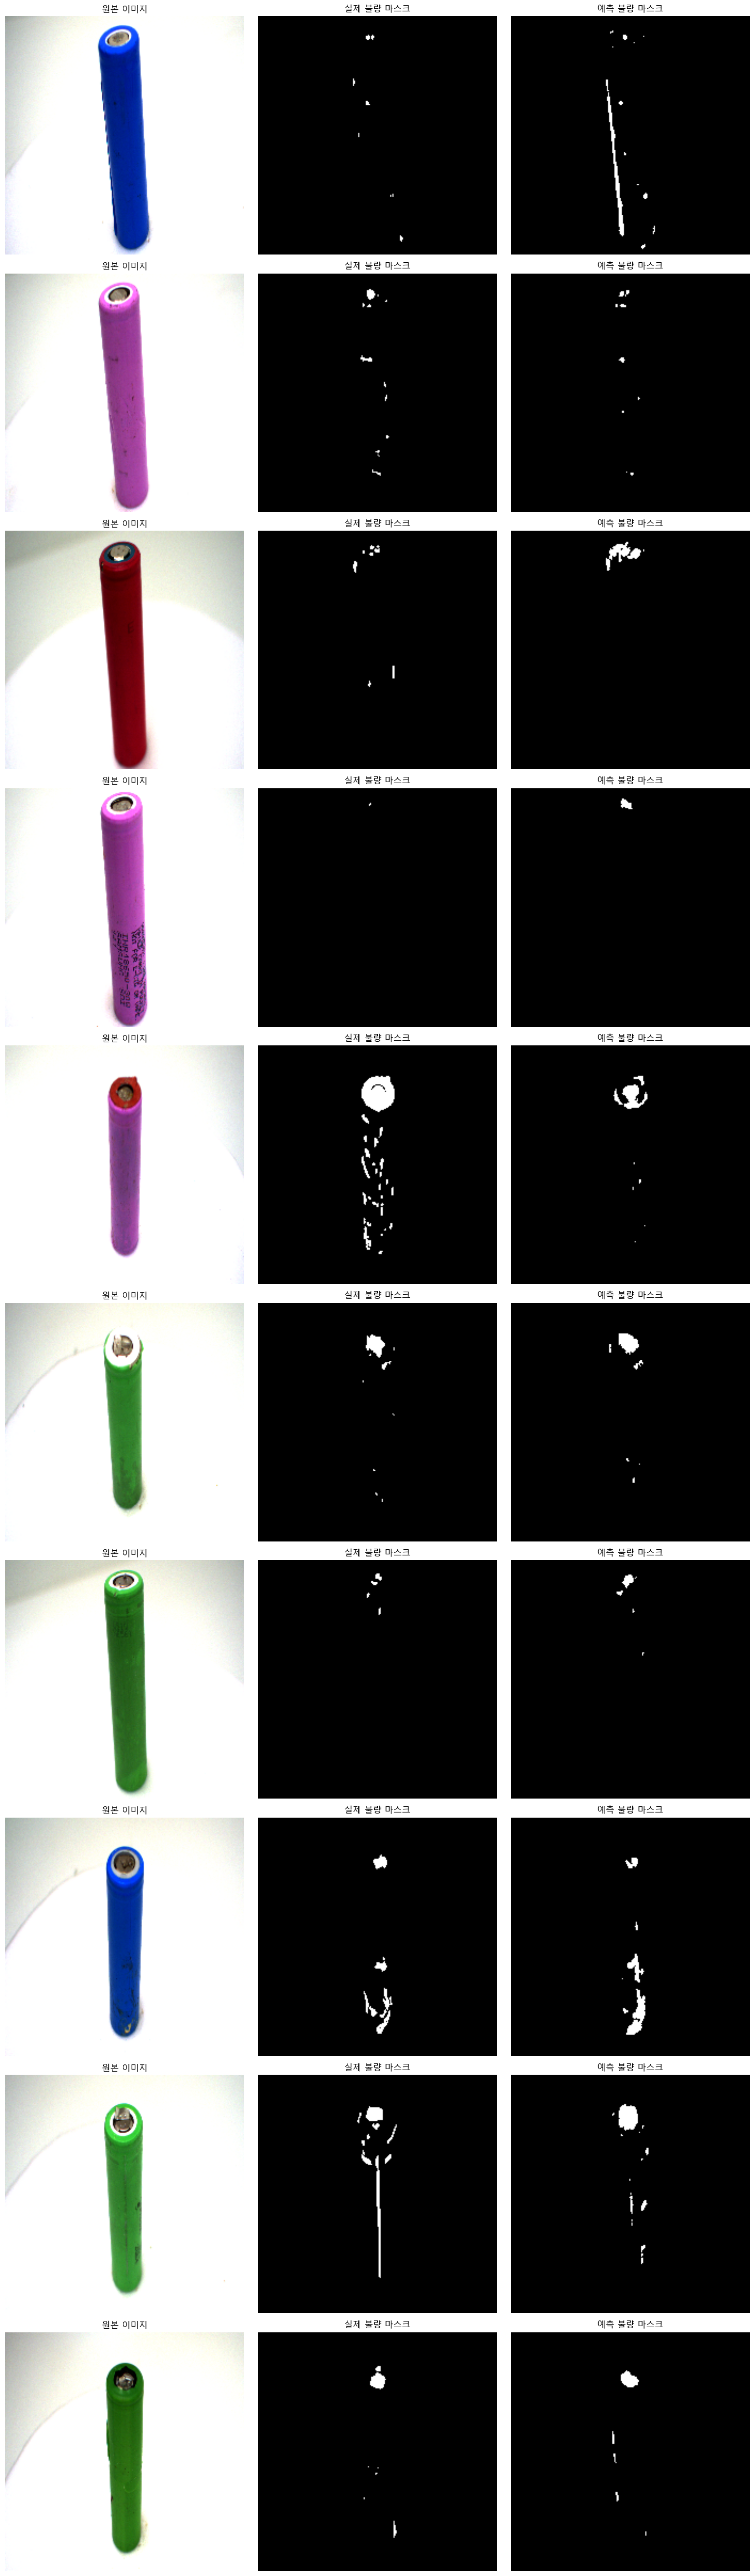

In [8]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 경로 설정
image_dir = r"D:/sample_ex3000/test/images"
mask_dir = r"D:/sample_ex3000/test/masks_binary"      # 실제 마스크
model_path = "fine_tuned_unet_mobilenet_alpha08.h5"

# 모델 불러오기
model = load_model(model_path, compile=False)

# 이미지 선택
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg'))]
selected_images = random.sample(image_files, 10)

# 시각화 준비
fig, axes = plt.subplots(len(selected_images), 3, figsize=(15, 5 * len(selected_images)))

for i, img_name in enumerate(selected_images):
    # ===== 1. 원본 이미지 =====
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0

    # ===== 2. 실제 마스크 =====
    mask_path = os.path.join(mask_dir, img_name)
    if not os.path.exists(mask_path):
        print(f"실제 마스크 없음: {img_name}")
        continue
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask = cv2.resize(true_mask, (224, 224))
    true_mask = (true_mask > 127).astype(np.uint8)

    # ===== 3. 예측 마스크 =====
    pred_mask = model.predict(np.expand_dims(img_resized, axis=0))[0]
    pred_mask = (pred_mask > 0.51).astype(np.uint8).squeeze()

    # ===== 시각화 =====
    axes[i, 0].imshow(img)
    axes[i, 0].set_title("원본 이미지")
    axes[i, 1].imshow(true_mask, cmap="gray")
    axes[i, 1].set_title("실제 불량 마스크")
    axes[i, 2].imshow(pred_mask, cmap="gray")
    axes[i, 2].set_title("예측 불량 마스크")

    for j in range(3):
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


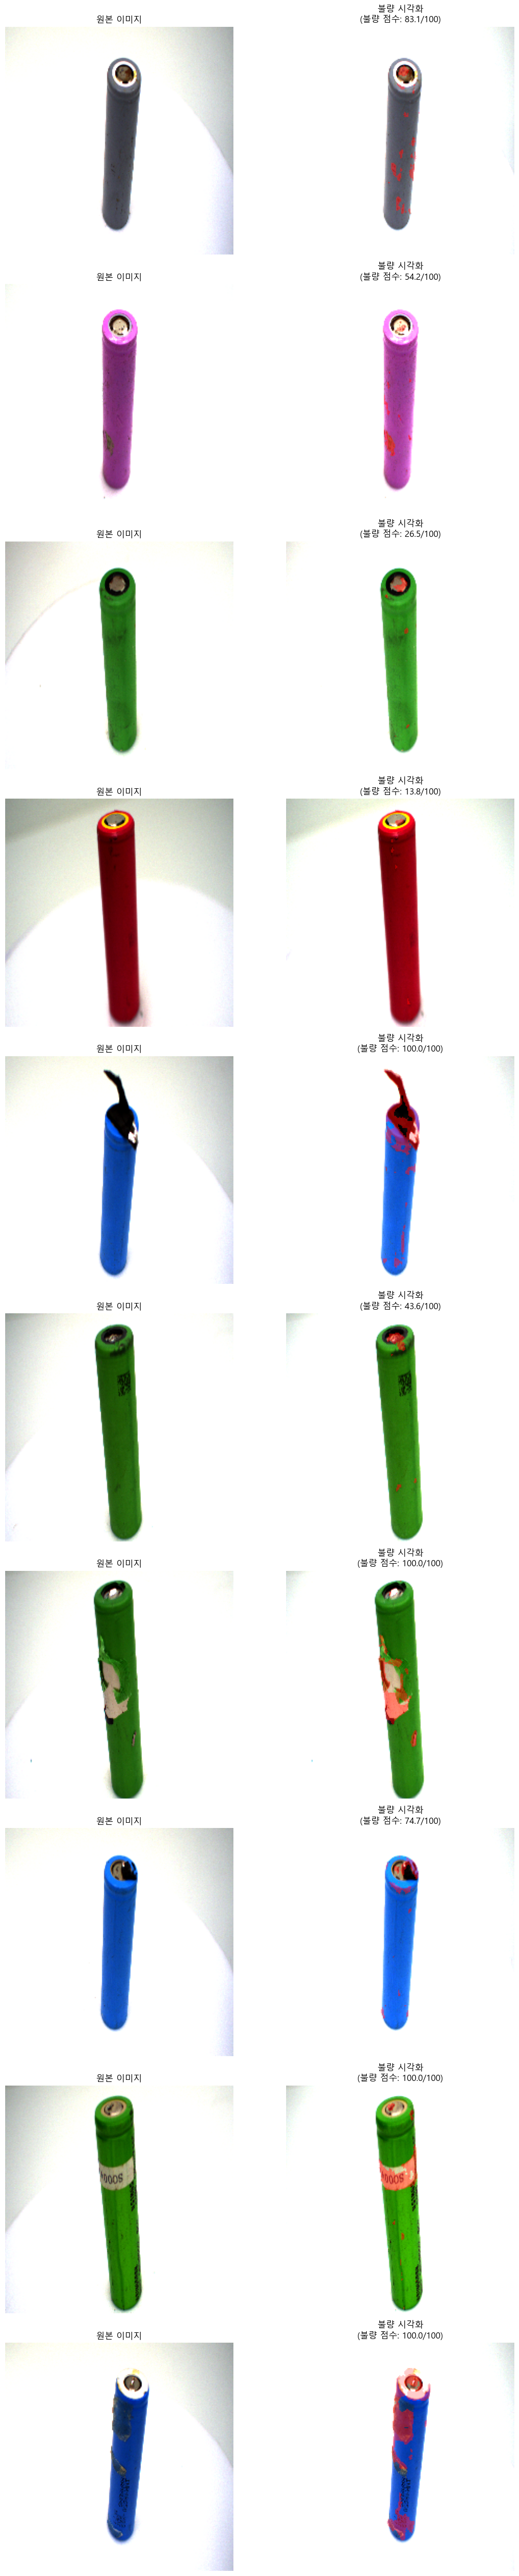

In [96]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 경로 설정
image_dir = r"C:\sample_ex3000\filtered_defect\test\images"
model_path = "fine_tuned_unet_mobilenet_alpha08.h5" 

# 모델 불러오기
model = load_model(model_path, compile=False)

# 랜덤 10개 이미지 선택
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(image_files, 10)

# 이미지 예측 및 시각화
fig, axes = plt.subplots(10, 2, figsize=(12, 50))

for i, img_name in enumerate(selected_images):
    # 이미지 로드 및 전처리
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0  # 정규화

    # 모델 예측
    pred_mask = model.predict(np.expand_dims(img_resized, axis=0))[0]
    pred_mask = (pred_mask > 0.51).astype(np.uint8)  # 최적 Threshold 적용 (0.27)

    # 불량 픽셀 비율 계산 (100점 만점 변환)
    defect_ratio = np.sum(pred_mask) / (224 * 224)  # 전체 픽셀 대비 불량 픽셀 비율
    defect_score = min(defect_ratio * 10000, 100)  # **불량 픽셀 비율을 100점 기준으로 변환**

    # 배경 유지 + 불량 부분만 빨간색으로 덧씌우기
    mask_colored = img_resized.copy() * 255  # 원본 유지
    mask_colored[:, :, 0] = np.where(pred_mask[:, :, 0] == 1, 255, mask_colored[:, :, 0])  # 빨간색 채널
    mask_colored[:, :, 1] = np.where(pred_mask[:, :, 0] == 1, 0, mask_colored[:, :, 1])  # 초록색 제거
    mask_colored[:, :, 2] = np.where(pred_mask[:, :, 0] == 1, 0, mask_colored[:, :, 2])  # 파란색 제거

    overlay = cv2.addWeighted((img_resized * 255).astype(np.uint8), 0.8, mask_colored.astype(np.uint8), 0.5, 0)

    # 원본 & 마스크 시각화
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"원본 이미지", fontsize=12)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title(f"불량 시각화\n(불량 점수: {defect_score:.1f}/100)", fontsize=12)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


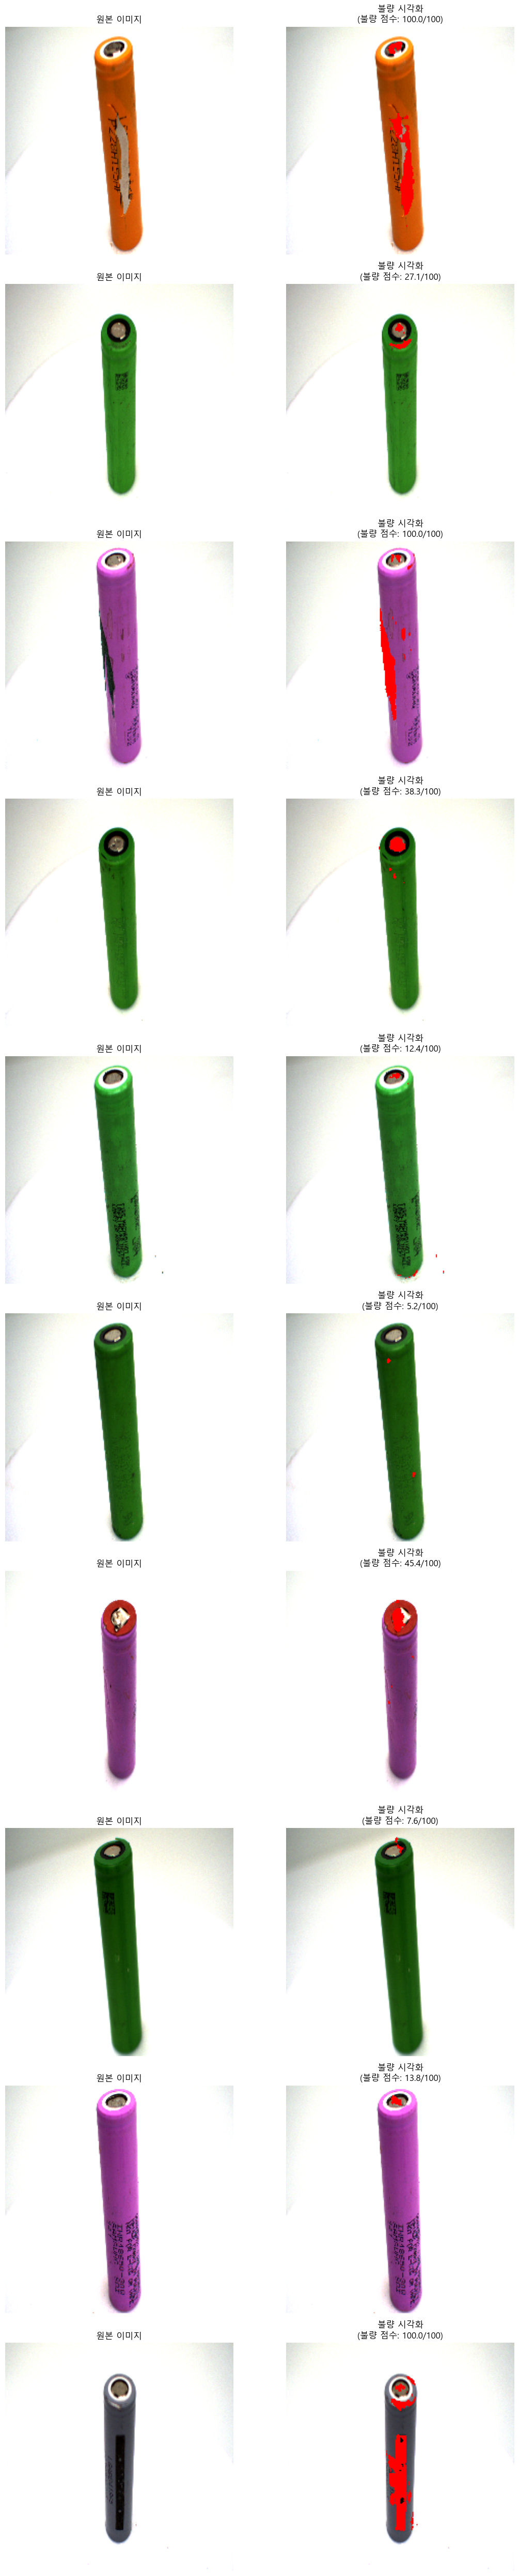

In [100]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# 경로 설정
image_dir = r"C:\sample_ex3000\filtered_defect\test\images"
model_path = "fine_tuned_unet_mobilenet_alpha08.h5"  

# 모델 불러오기
model = load_model(model_path, compile=False)

# 랜덤 10개 이미지 선택
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
selected_images = random.sample(image_files, 10)

# 이미지 예측 및 시각화
fig, axes = plt.subplots(10, 2, figsize=(12, 50))

for i, img_name in enumerate(selected_images):
    # 이미지 로드 및 전처리
    img_path = os.path.join(image_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224)).astype(np.float32) / 255.0  # 정규화

    # 모델 예측
    pred_mask = model.predict(np.expand_dims(img_resized, axis=0))[0]
    pred_mask = (pred_mask > 0.51).astype(np.uint8)  # 최적 Threshold 적용

    # 불량 픽셀 비율 계산 (100점 만점 변환)
    defect_ratio = np.sum(pred_mask) / (224 * 224)  # 전체 픽셀 대비 불량 픽셀 비율
    defect_score = min(defect_ratio * 10000, 100)  # 불량 픽셀 비율을 100점 기준으로 변환

    # 원본 이미지 유지 + 불량 부분만 빨간색으로 덧씌우기
    mask_colored = np.zeros_like(img_resized)  # 마스크 초기화 (배경은 투명)
    mask_colored[:, :, 0] = pred_mask[:, :, 0] * 255  # 빨간색 채널
    mask_colored[:, :, 1] = 0  # 초록색 0
    mask_colored[:, :, 2] = 0  # 파란색 0

    # 원본 유지하면서 불량 영역만 강한 빨강으로 오버레이
    overlay = img_resized * 255  # 원본 유지
    overlay = overlay.astype(np.uint8)
    overlay[pred_mask[:, :, 0] == 1] = [255, 0, 0]  # 불량 부분만 빨강

    # 원본 & 마스크 시각화
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"원본 이미지", fontsize=12)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(overlay)
    axes[i, 1].set_title(f"불량 시각화\n(불량 점수: {defect_score:.1f}/100)", fontsize=12)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()